##### Fast Campus Data Science School 7th Team Project 2

# [Walmart : Triptype Classification](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification)

<img src="data/walmart.jpg">

# [ Overview ]

### (1) Team : SWYA 
> - 김선웅 [팀원]
> - 서원영 [팀원]
> - 백윤아 [팀장]

### (2) Dataset : 
> #### Walmart Shopping Records

### (3) Objective : 
> #### 각 고객의 구매정보에 따른 구매 건의 Type을 분류

<br>

# [Data Description]

> #### train : 647054 rows, 7 columns
> #### test : 653646 rows, 6 columns
> - 타겟값 TripType을 제외한 동일한 특성의 컬럼

| Index | Feature               | Description                                  | Unique |
|-------|-----------------------|----------------------------------------------|--------|
| 1     | TripType              | Target                                       | 38     |
| 2     | VisitNumber           | 각 손님의 Index                              | 95674  |
| 3     | Weekday               | VisitNumber가 발생한 요일                    | 7      |
| 4     | Upc                   | 구매한 제품의 고유한 바코드                  | 97715  |
| 5     | ScanCount             | 구매 수량 ( 반품 시 - 값으로 표기 )          | 39     |
| 6     | DepartmentDescription | 제품의 대분류                                | 69     |
| 7     | FinelineNumber        | 월마트 자체적으로 정의 한 제품의 소분류 코드 | 5196   |

> #### UPC code description
- Check Digit : 숫자가 정확하게 구성되어 있는가를 보장해주는 컴퓨터 검증 숫자. UPC의 신뢰도를 검증

<img src="data/upc.png">


<br>


# [Evaluation]
> ### Multi-class log loss (Cross Entropy)
> $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$
- $N$ : the number of visits in the test set
- $M$ : the number of trip types
- $\log$ : natural logarithm
- $y_{ij}$ : 1 if observation i is of class j and 0 otherwise
- $p_{ij}$ : the predicted probability that observation i belongs to class j

# [Contents]

### (1) EDA & Preprocessing
> - Missing Values
> - Encoding Weekday 
> - Uneven Distribution of TripType
> - Most Frequent & Least Frequent TripType

### (2) Feature Engineering
> - UPC decoding
> - ScanCount seperation
> - Feature encoding
> - Dummy variables
> - Identifing the most frequently purchased items per VisitNumber

### (3) Modeling
> - RandomForest
> - XGBoost

### (4) Results
> - Logarithmic loss : 0.78259
> - Accuracy score : 73.68%
> - Feature Importance Top 20

### (5) Kaggle Submission
> - Total Teams : 1,047 teams 
> - Final Score : 0.79154
> - Leaderboard : 294 / 1,047 (Top 30%)


* * *

## (1) EDA & Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_formats = {'png', 'retina'}

from walmart_utils import *

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [2]:
train.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


### Missing Values

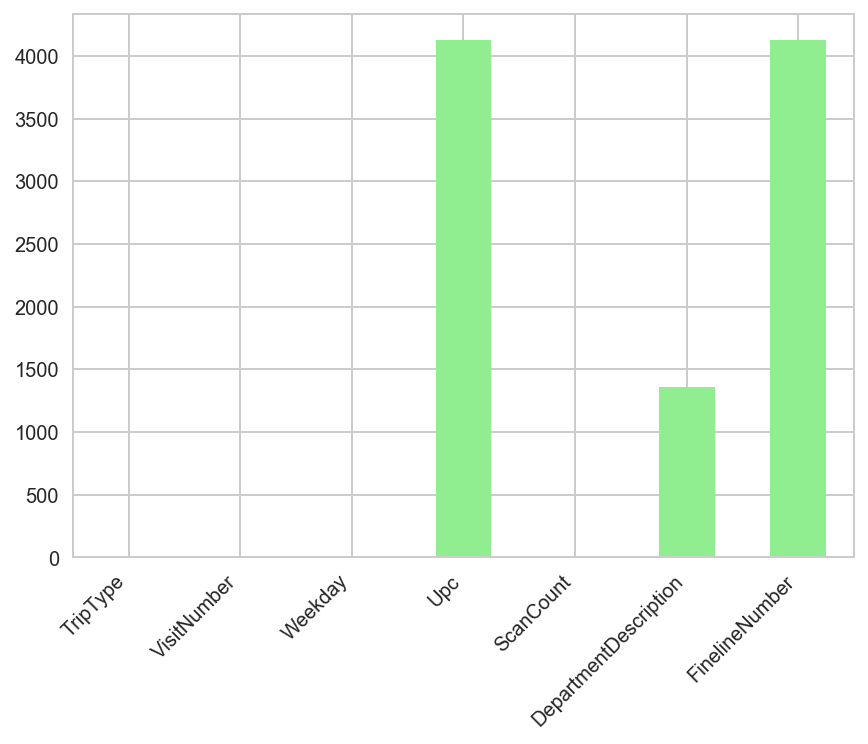

In [8]:
plt.figure(figsize=(7, 5))
train.isnull().sum().plot(kind='bar', color="lightgreen")
plt.xticks(rotation=45, ha='right')
plt.show()

- Upc, DepartmentDescription, FinelineNumber에 Missing Values 존재
- Upc와 FinelineNumber의 Missing Values는 동시에 나타남
- Missing Value 제거 시 사라지는 VisitNumber 존재
- Feature Engineering에서 VisitNumber에 대한 테이블로 변경
- 최종 모델링 시 Nan은 0으로 처리

### Encoding Weekday 

In [125]:
wd = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
      "Friday": 4, "Saturday": 5, "Sunday": 6}
train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])
test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

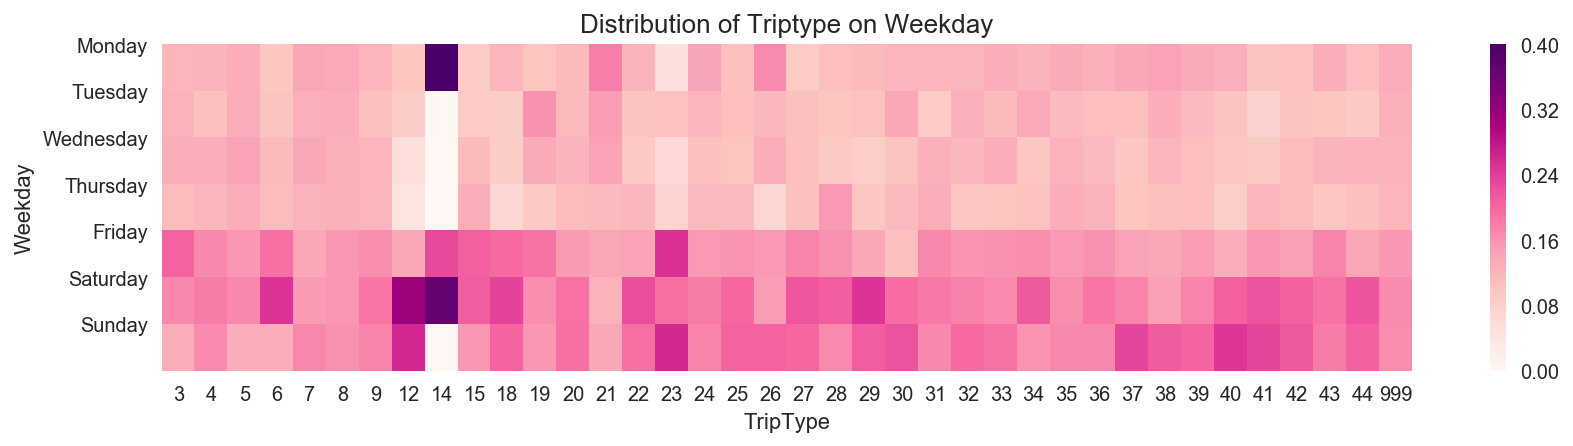

In [126]:
plt.figure(figsize=(14, 3))

sns.heatmap(data=pd.crosstab(train["Weekday"],
                             train["TripType"], 
                             values=train["VisitNumber"],
                             aggfunc='count', 
                             normalize="columns"), cmap="RdPu")
plt.yticks(range(0,7), list(wd.keys()), rotation="horizontal")
plt.title("Distribution of Triptype on Weekday", fontsize=13)
plt.show()

- TripType 14는 월, 금/토에 많이 나타남
- Feature에 반영 (One-Hot Encoding)

### Uneven Distribution of TripType

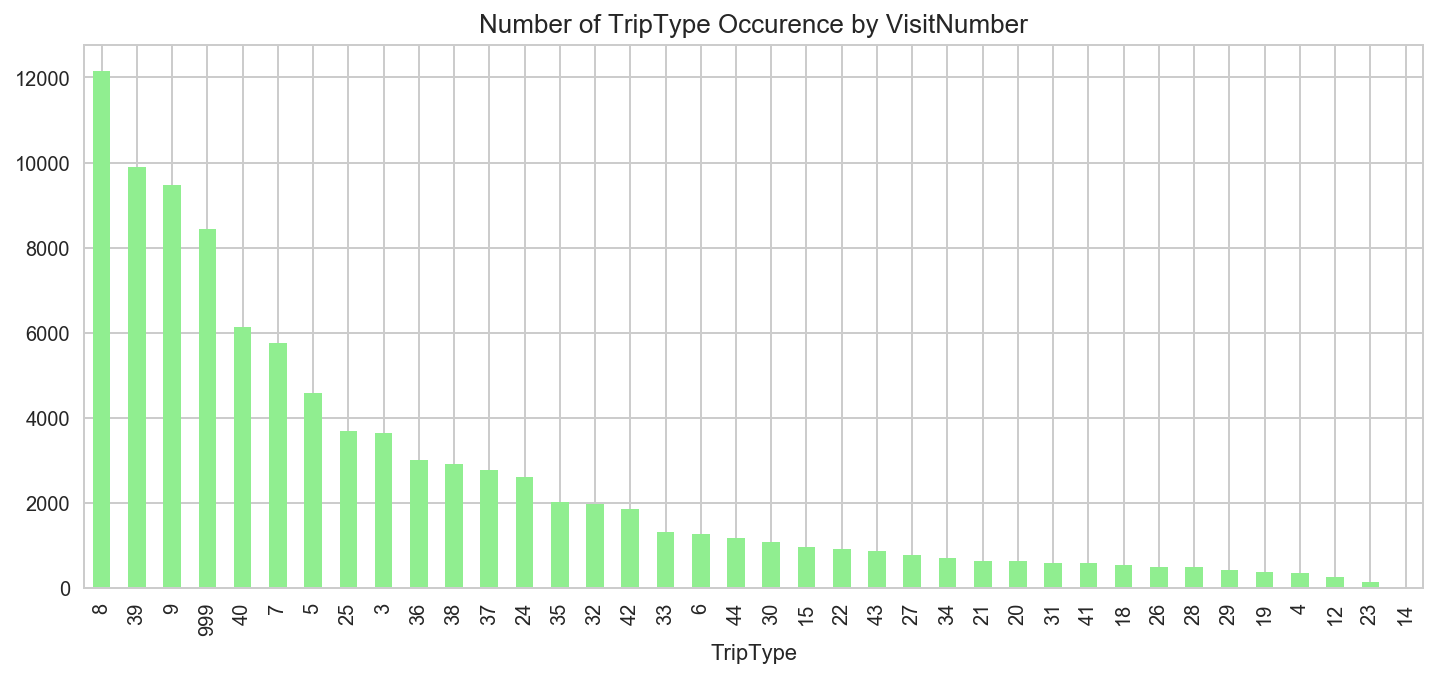

In [9]:
plt.figure(figsize=(12, 5))

sns.set_style('whitegrid')
np.sort(train.TripType.unique())
train_triptypes = train.drop_duplicates("VisitNumber")
a = train_triptypes["TripType"]
a = a.value_counts()
a.plot(kind='bar', color="lightgreen")
plt.title("Number of TripType Occurence by VisitNumber", fontsize=13)
plt.xlabel("TripType")

plt.show()

In [10]:
train_40 = train[train["TripType"]==40]
train_40["DepartmentDescription"].value_counts()[:10]

GROCERY DRY GOODS           32639
DSD GROCERY                 22157
DAIRY                       17354
PRODUCE                     16704
PERSONAL CARE                9911
FROZEN FOODS                 9307
HOUSEHOLD CHEMICALS/SUPP     8093
COMM BREAD                   5968
HOUSEHOLD PAPER GOODS        5712
PHARMACY OTC                 4569
Name: DepartmentDescription, dtype: int64

### Most Frequent & Least Frequent TripType

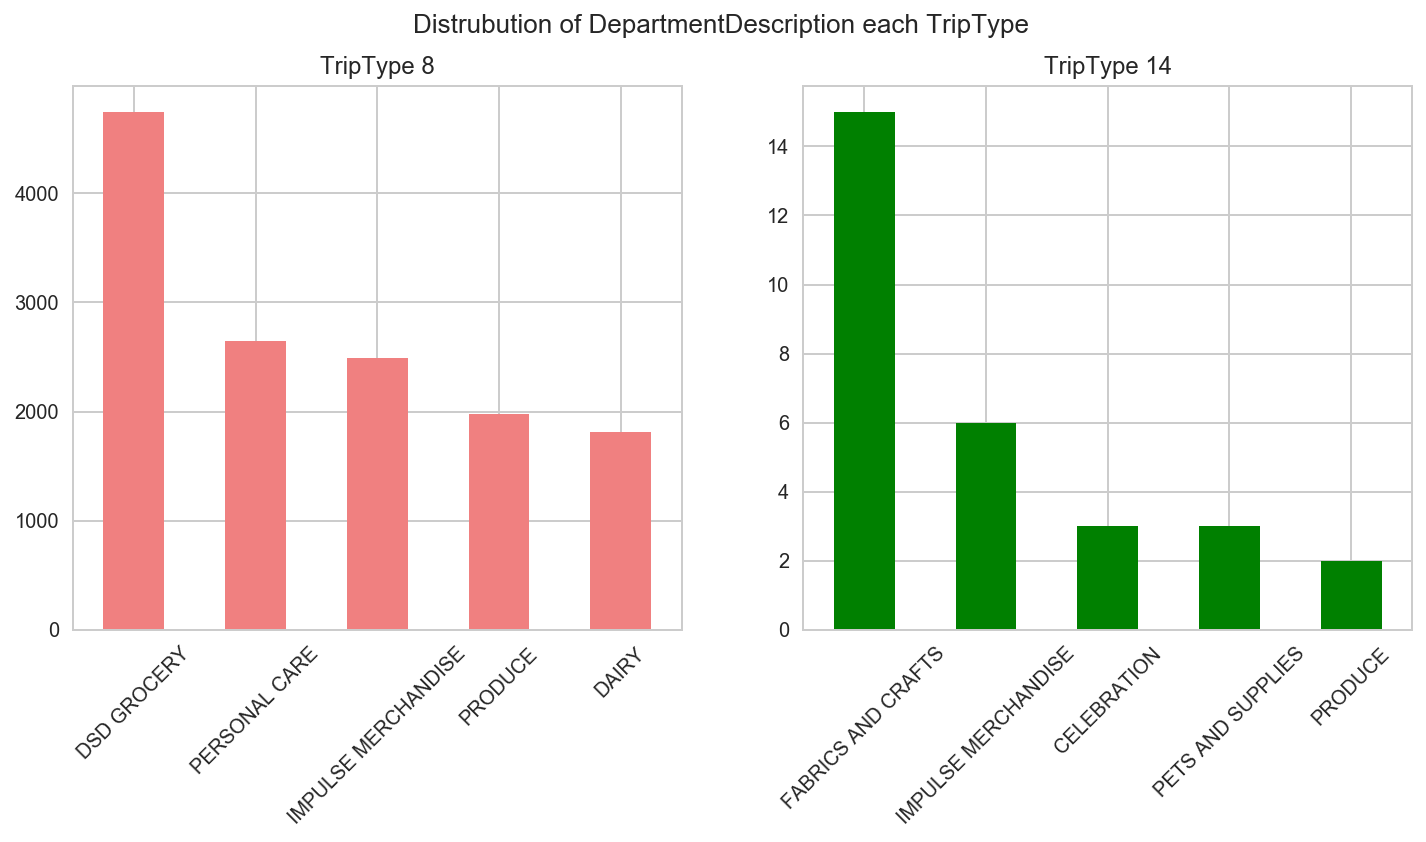

In [12]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
type_8 = train[train.TripType == 8]
type_8_items = type_8[["TripType","DepartmentDescription"]]
type_8_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="TripType 8", color="lightcoral")
ax1 = fig.add_subplot(122)
type_14 = train[train.TripType == 14]
type_14_items = type_14[["TripType","DepartmentDescription"]]
type_14_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="TripType 14", color="green")

fig.suptitle("Distrubution of DepartmentDescription each TripType", fontsize=13)
plt.xticks(fontsize=10)
plt.show()

- 가장 많은 TripType과 적은 TripType에서 등장하는 DepartmentDescription의 차이 존재
- 하나의 Department에서만 구매한 것이 아닌 여러 Department에서 구매함
- Feature Engineering에서 DepartmentDescription Encoding과 Multi-Single Department 여부 반영 (Dummy, CategoryCounts)

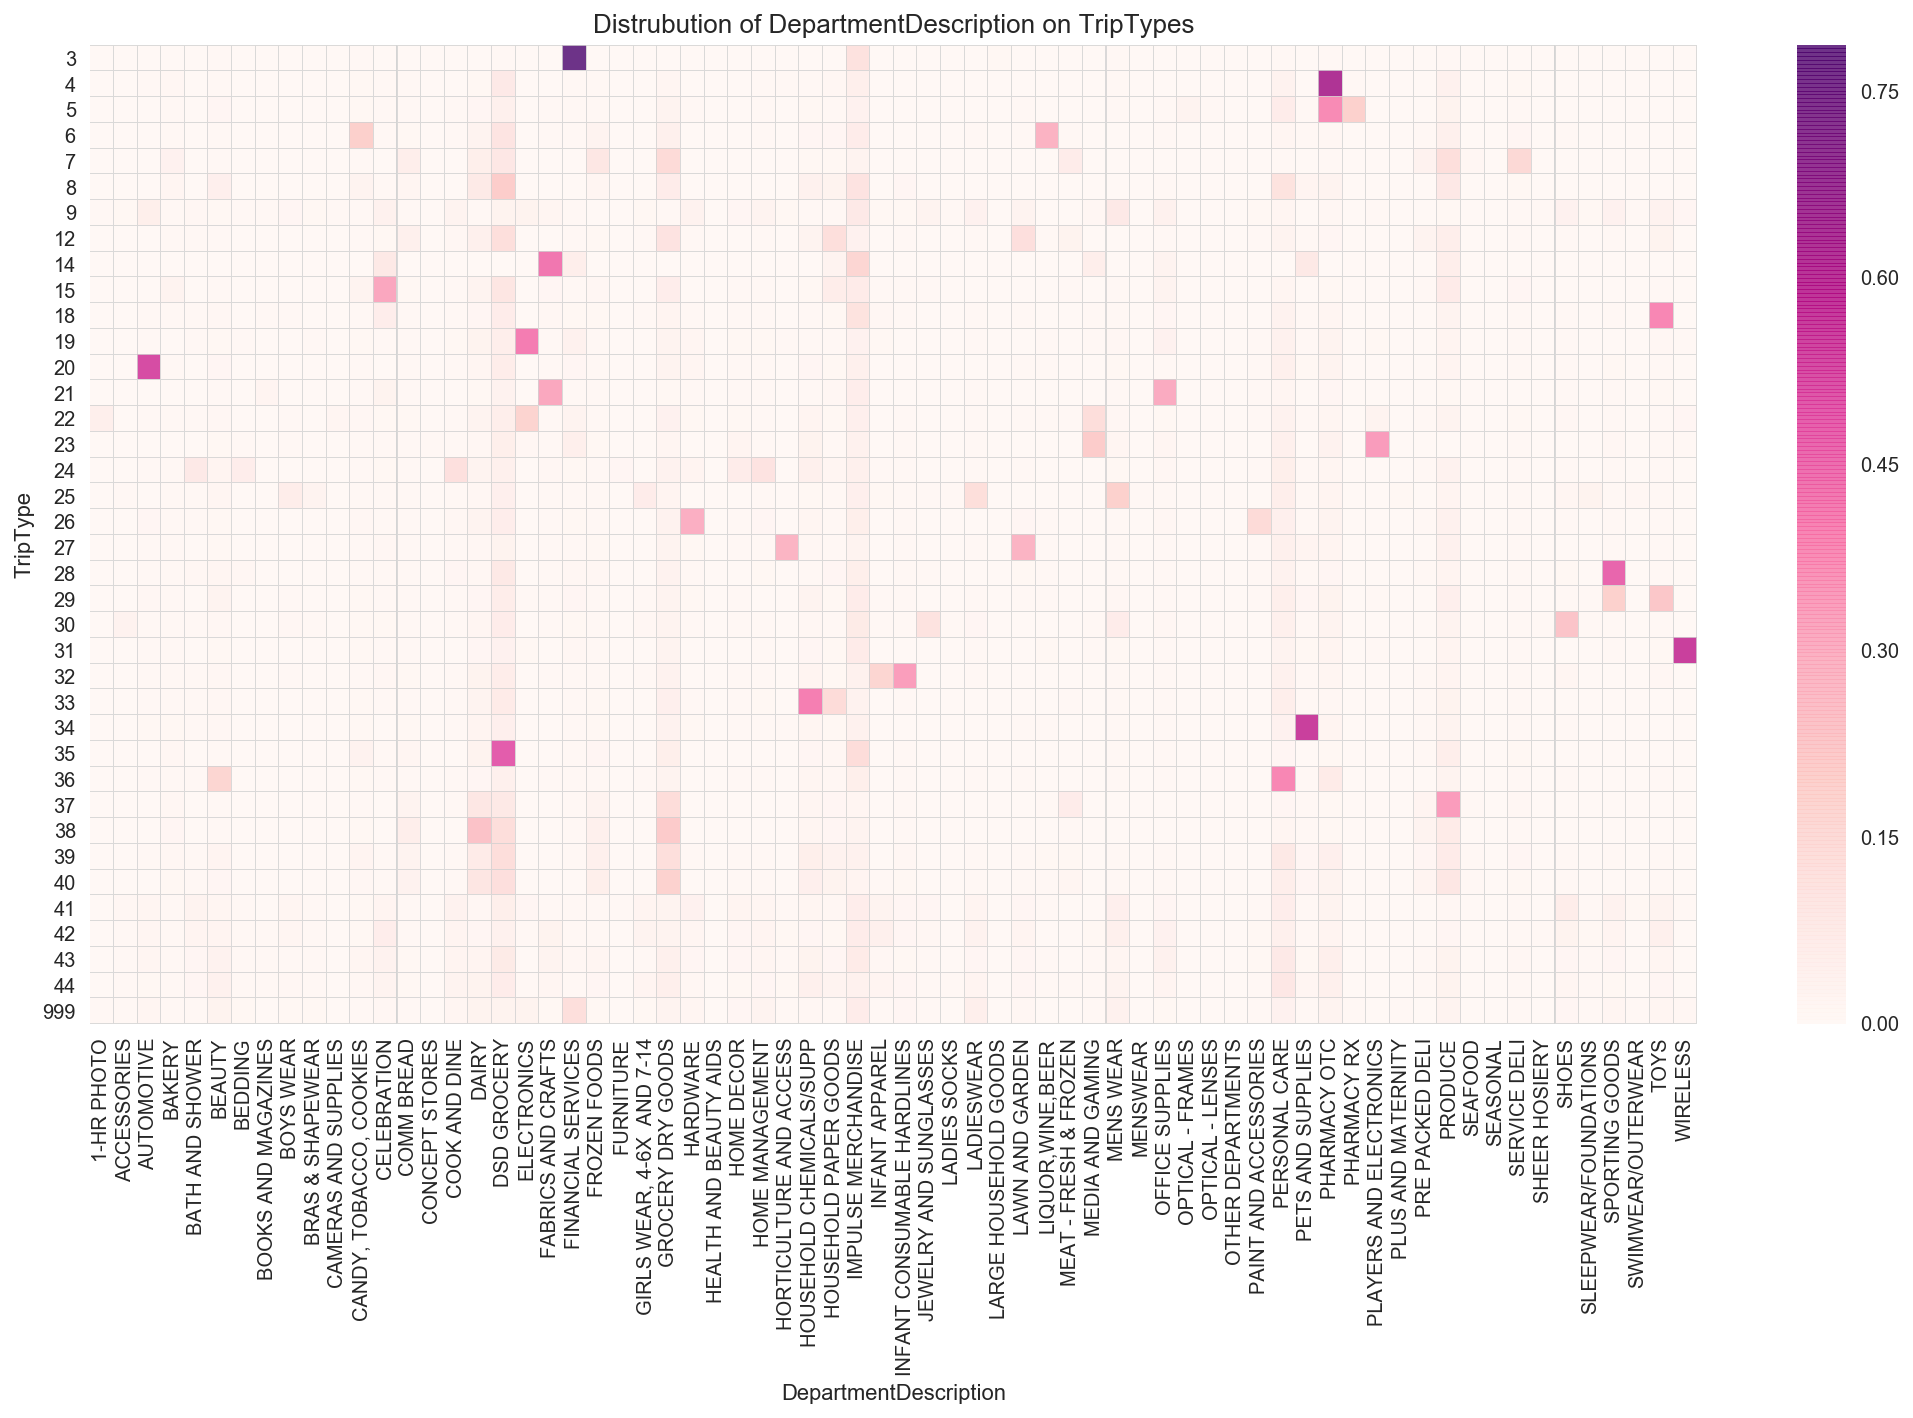

In [130]:
trip_desc = pd.crosstab(train["TripType"], 
                        train["DepartmentDescription"], 
                        values=train["ScanCount"], 
                        aggfunc="count", 
                        normalize="index")

plt.figure(figsize=(18, 9))
sns.heatmap(trip_desc, linecolor="lightgrey", linewidths=0.02, cmap="RdPu", alpha=.8)
plt.title("Distrubution of DepartmentDescription on TripTypes", fontsize=13)
plt.show()

- 비슷한 Department에서 물건 구매시 TripType 분류에 영향을 미치는 것으로 보임
- 하나의 Department에서만 구매한 것이 아닌 여러 Department에서 구매함
- 복수의 Department 방문 여부를 Feature에 반영 (CategoryCounts)

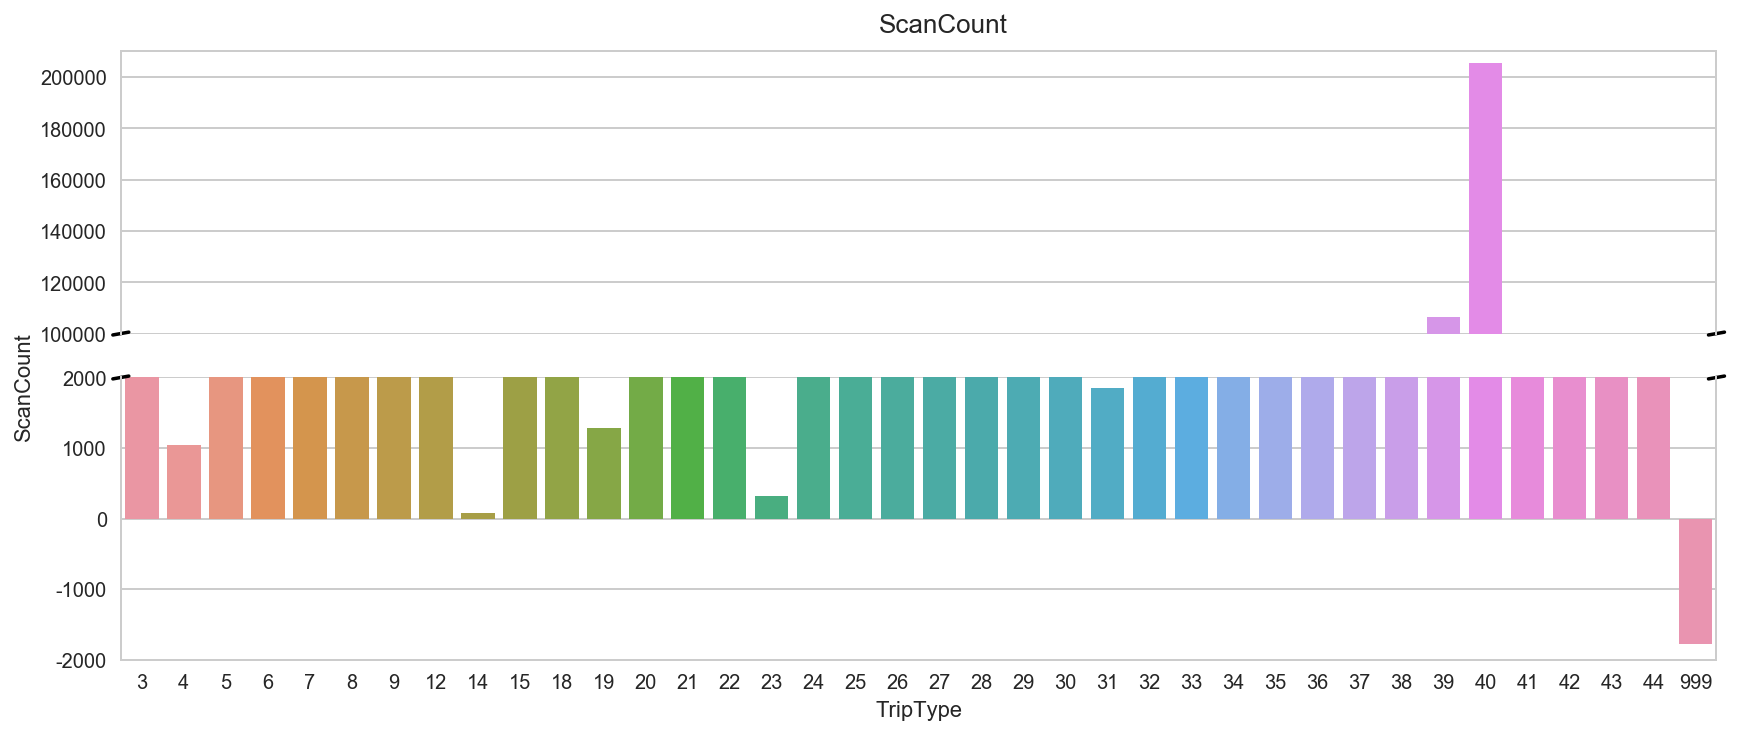

In [131]:
train_plot = train[["TripType", "ScanCount"]]
plot_grouped = train_plot.groupby("TripType", as_index=False).sum()

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
sns.barplot(x="TripType", y="ScanCount", data=plot_grouped, ax=ax)
sns.barplot(x="TripType", y="ScanCount", data=plot_grouped, ax=ax2)

ax.set_ylim(100000, 210000)
ax2.set_ylim(-2000, 2000)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off') 
ax2.xaxis.tick_bottom()

d = .005

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) 

f.text(0, 0.5, 'ScanCount', va='center', rotation='vertical', fontsize=11)
f.text(0.5, 1, 'ScanCount', va='center', rotation='horizontal', fontsize=13)
plt.tight_layout()
plt.show()

- TripType 999는 반품을 위한 방문이라고 생각됨
- Return 여부를 Feature에 반영 (Return)
- ScanCount를 실제 판매수량과 반품으로 나누어서 Feature에 반영 (Pos_Sum, Neg_Sum)

## (2) Featuer Engineering

### Decode company code from UPC

In [132]:
train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Upc.apply(company) 
test["company"] = test.Upc.apply(company)

### Return Indicator

In [133]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

### Positive ScanCount (The number of sold)

In [134]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

### Negative ScanCount (The number of returns)

In [135]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [136]:
print(train.shape)
train.tail()

(647054, 11)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum,Neg_Sum
647049,39,191346,6,32390001778,1,PHARMACY OTC,1118.0,323900,0.0,1,0
647050,39,191346,6,7874205336,1,FROZEN FOODS,1752.0,787420,0.0,1,0
647051,39,191346,6,4072,1,PRODUCE,4170.0,4072,0.0,1,0
647052,8,191347,6,4190007664,1,DAIRY,1512.0,419000,0.0,1,0
647053,8,191347,6,3800059655,1,GROCERY DRY GOODS,3600.0,380005,0.0,1,0


### FinelineNumber most frequently appear

In [137]:
train_fineline = train[["VisitNumber", "FinelineNumber"]]
train_fineline = train_fineline.groupby("VisitNumber", as_index=False).agg(mode)
train_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

test_fineline = test[["VisitNumber", "FinelineNumber"]]
test_fineline = test_fineline.groupby("VisitNumber", as_index=False).agg(mode)
test_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

### The number of UPC and  FinelineNumber for each VisitNumber

In [139]:
train_upc_fine = train[["VisitNumber", "Upc", "FinelineNumber"]]
test_upc_fine = test[["VisitNumber", "Upc", "FinelineNumber"]]

train_upc_fine_group = train_upc_fine.groupby("VisitNumber", as_index=False).count()
train_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                     "FinelineNumber": "N_FinelineNumber"}, inplace=True)
test_upc_fine_group = test_upc_fine.groupby("VisitNumber", as_index=False).count()
test_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                    "FinelineNumber": "N_FinelineNumber"}, inplace=True)

In [140]:
train.drop(["Upc", "FinelineNumber"], axis=1, inplace=True)
test.drop(["Upc", "FinelineNumber"], axis=1, inplace=True)

### One-Hot Encoding of DepartmentDescription

In [141]:
train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()

In [142]:
train_dd.tail()

,VisitNumber,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
95669,191343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191344,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
95671,191345,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### CompanyNumber for the most purchased product for each VisitNumber

In [143]:
train_company = train[["VisitNumber", "company"]]
test_company = test[["VisitNumber", "company"]]

train_company = train_company.groupby("VisitNumber", as_index=False).agg(mode)
test_company = test_company.groupby("VisitNumber", as_index=False).agg(mode)

### Pivot table by VisitNumber

In [144]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train_by_max = train[["TripType", "VisitNumber", "Weekday", "Return"]]
test_by_max = test[["VisitNumber", "Weekday", "Return"]]

train_by_max = train_by_max.groupby("VisitNumber", as_index=False).max()
test_by_max = test_by_max.groupby("VisitNumber", as_index=False).max()

In [145]:
train = train_by_sum.merge(train_by_max, on=["VisitNumber"])
train = train.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_company, on=["VisitNumber"])
train = train.merge(train_fineline, on=["VisitNumber"])
train = train.merge(train_upc_fine_group, on=["VisitNumber"])

test = test_by_sum.merge(test_by_max, on=["VisitNumber"])
test = test.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_company, on=["VisitNumber"])
test = test.merge(test_fineline, on=["VisitNumber"])
test = test.merge(test_upc_fine_group, on=["VisitNumber"])

### Remove DepartmentDescription not shown in test data
### Segregate features & target

In [146]:
y = train["TripType"]
train = train.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)

### The counts of DepartmentDescription for each VistNumber

In [147]:
# from walmart_utils import category_counts
%time train = category_counts(train)
%time test = category_counts(test)

CPU times: user 8.49 s, sys: 11.3 ms, total: 8.5 s
Wall time: 8.51 s
CPU times: user 8.33 s, sys: 9.99 ms, total: 8.34 s
Wall time: 8.34 s


### Ratio of number of UPC and FinelineNumber

In [148]:
train["Upc_FLN"] = train["N_Upc"] / train["N_FinelineNumber"]
test["Upc_FLN"] = test["N_Upc"] / test["N_FinelineNumber"]

### One-Hot Encoding of Weeday and Return

In [162]:
train = pd.get_dummies(train, columns=["Weekday", "Return", "MF_DepartmentDescription"])
test = pd.get_dummies(test, columns=["Weekday", "Return", "MF_DepartmentDescription"])

In [149]:
vn = test[["VisitNumber"]]
train.drop("VisitNumber", axis=1, inplace=True)
test.drop("VisitNumber", axis=1, inplace=True)

### Replace Null Value, Inf Value with 0

In [150]:
train.replace(np.inf, 0, inplace=True)
train.fillna(value=0, inplace=True)

test.replace(np.inf, 0, inplace=True)
test.fillna(value=0, inplace=True)

### Final Data

In [163]:
train.tail()

,ScanCount,Pos_Sum,Neg_Sum,CategoryCounts,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,...,MF_DepartmentDescription_SEAFOOD,MF_DepartmentDescription_SEASONAL,MF_DepartmentDescription_SERVICE DELI,MF_DepartmentDescription_SHEER HOSIERY,MF_DepartmentDescription_SHOES,MF_DepartmentDescription_SLEEPWEAR/FOUNDATIONS,MF_DepartmentDescription_SPORTING GOODS,MF_DepartmentDescription_SWIMWEAR/OUTERWEAR,MF_DepartmentDescription_TOYS,MF_DepartmentDescription_WIRELESS
95669,9,9,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,5,5,0,2,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
95671,17,17,0,8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
95672,17,17,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,2,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* * * 

## (3) Modeling

### - Model Trial (Test Score)
- Logistic Regression: 0.62
- QDA: 0.042
- LDA: 0.511
- Random Forest: 0.65 (Best Kaggle Score: 1.12)
    - ( parameters: `n_estimator`: 1000, `max_features`: 0.8, `min_sample_split`: 30 )

### - Final Model
- XGBoost

### - Final Features (Total 86)

- ScanCount
- Return (dummies)
- Pos_Sum
- Neg_Sum
- CategoryCounts
- DepartmentDescription (dummies)
- Company code
- MF_Fineline (Most Frequent FinelineNumbers)
- MF_DepartmentDescription (Most Frequent DepartmentDescription)
- N_UPC (The number of UPC
- N_FinelineNumber (The number of FinelineNumber)
- UPC_FLN (N_UPC / N_FinelineNumber)
- Weekday (dummies)

In [178]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [119]:
label_enc = LabelEncoder().fit(y)
y_labeled = label_enc.transform(y)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y_labeled, random_state=0)

In [180]:
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [181]:
num_boost_round = 300
params = {'objective': 'multi:softprob', 
          'eval_metric': 'mlogloss',
          'num_class':38, 
          'max_delta_step': 3, 
          'eta': 0.2}

evals = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
                early_stopping_rounds=10,)

[0]	train-mlogloss:3.07295	eval-mlogloss:3.08218
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.57164	eval-mlogloss:2.59177
[2]	train-mlogloss:2.17018	eval-mlogloss:2.2036
[3]	train-mlogloss:1.87296	eval-mlogloss:1.91539
[4]	train-mlogloss:1.67639	eval-mlogloss:1.72582
[5]	train-mlogloss:1.52843	eval-mlogloss:1.58453
[6]	train-mlogloss:1.41329	eval-mlogloss:1.47551
[7]	train-mlogloss:1.31861	eval-mlogloss:1.38702
[8]	train-mlogloss:1.24043	eval-mlogloss:1.31458
[9]	train-mlogloss:1.17416	eval-mlogloss:1.25374
[10]	train-mlogloss:1.11823	eval-mlogloss:1.20231
[11]	train-mlogloss:1.06992	eval-mlogloss:1.1589
[12]	train-mlogloss:1.02704	eval-mlogloss:1.12072
[13]	train-mlogloss:0.990042	eval-mlogloss:1.08826
[14]	train-mlogloss:0.957684	eval-mlogloss:1.06011
[15]	train-mlogloss:0.929533	eval-mlogloss:1.03638
[16]	train-mlogloss:0.903919	eval-mlogloss:1.01477
[17]	tr

[155]	train-mlogloss:0.396035	eval-mlogloss:0.781884
[156]	train-mlogloss:0.394652	eval-mlogloss:0.781909
[157]	train-mlogloss:0.393307	eval-mlogloss:0.781885
[158]	train-mlogloss:0.392108	eval-mlogloss:0.781844
[159]	train-mlogloss:0.39104	eval-mlogloss:0.781879
[160]	train-mlogloss:0.389667	eval-mlogloss:0.781767
[161]	train-mlogloss:0.388478	eval-mlogloss:0.781697
[162]	train-mlogloss:0.387195	eval-mlogloss:0.781714
[163]	train-mlogloss:0.385982	eval-mlogloss:0.781793
[164]	train-mlogloss:0.384736	eval-mlogloss:0.781596
[165]	train-mlogloss:0.383621	eval-mlogloss:0.78169
[166]	train-mlogloss:0.38242	eval-mlogloss:0.781675
[167]	train-mlogloss:0.38096	eval-mlogloss:0.781543
[168]	train-mlogloss:0.379627	eval-mlogloss:0.781712
[169]	train-mlogloss:0.378394	eval-mlogloss:0.781837
[170]	train-mlogloss:0.376918	eval-mlogloss:0.781782
[171]	train-mlogloss:0.375667	eval-mlogloss:0.781747
[172]	train-mlogloss:0.374691	eval-mlogloss:0.781904
[173]	train-mlogloss:0.373491	eval-mlogloss:0.7821

## (4) Results

### Logarithmic loss

In [182]:
from sklearn.metrics import log_loss
my_test = xgb.DMatrix(X_test.values)
test_predictions = bst.predict(my_test)
print("log loss :", log_loss(y_test, test_predictions).round(5))

log loss : 0.78259


### Accuracy score

In [184]:
yprob = test_predictions.reshape(y_test.shape[0], 38)
ylabel = np.argmax(yprob, axis=1)
accuracy = 100 *(1 - (sum(int(ylabel[i]) != y_test[i]
                         for i in range(len(y_test))) / float(len(y_test))))
print("TripType Accuracy = %.2f%%" % accuracy)

TripType Accuracy = 73.68%


### Featue Importance

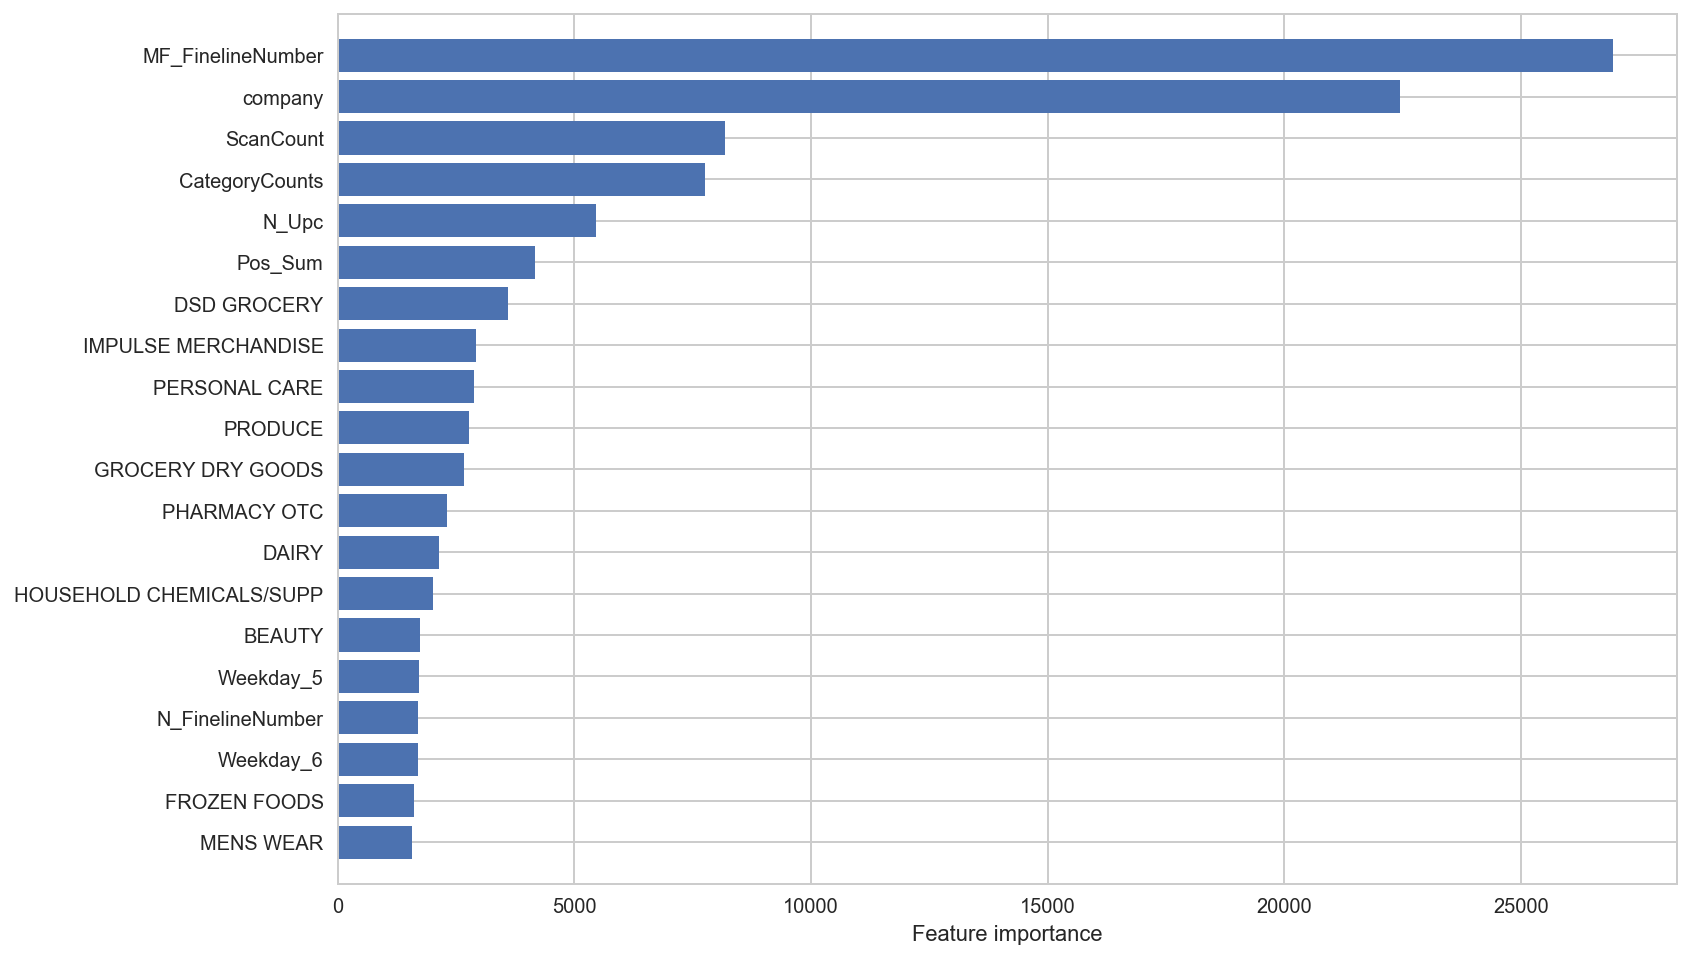

In [183]:
import operator
importance_dict = bst.get_score()
sorted_dict = sorted(importance_dict.items(), key=operator.itemgetter(1))
sorted_dict = sorted_dict[::-1]

indices = []
for i in range(len(sorted_dict)-1):
    indices.append(sorted_dict[i][0])
    
indices = [int(idx[1:]) for idx in indices]

importance_features = []
for idx in indices:
    importance_features.append(train.columns[idx])

importance = list(bst.get_score().values())
importance = sorted(importance)
importance = importance[::-1]

pairs = list(zip(importance, importance_features))
labels = [label[1] for label in pairs]

plt.figure(figsize=(12, 8))
plt.barh(range(20), importance[:20][::-1], align="center")
plt.yticks(np.arange(20), labels[:20][::-1])
plt.xlabel("Feature importance")
plt.ylim(-1, 20)
plt.show()

## (5) Kaggle Submission

In [ ]:
classes = np.array(list(set(label_enc.inverse_transform(y_labeled))))

dmtest = xgb.DMatrix(test.values) 
pred_proba = bst.predict(dmtest)

proba_df = pd.DataFrame(pred_proba, columns=classes)
proba_df.columns = proba_df.columns.map(lambda x: "TripType_" + str(x))
sub_df = pd.concat([vn, proba_df], axis=1)
sub_df.to_csv("../../team_SWYA_submission.csv", index=False)

![](http://localhost:8888/files/teamproject_2_walmart/main_presentation/data/final_score.png)